In [7]:
import warnings
warnings.filterwarnings('ignore')


from datetime import datetime
from IPython.display import clear_output
import statistics
import math
import os
import cProfile
import gym
from gym import envs
import numpy as np
# Docs https://www.tensorflow.org/api_docs/python/
import tensorflow as tf
import tensorflow_probability as tfp
from random import random

from pprint import pprint

import matplotlib.pyplot as plt

import numpy as np
import os
import time

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import keras
import keras.applications as kapp
#from keras.datasets import cifar10


def pp(o):
    pprint(vars(o))
    
    
%load_ext tensorboard

print("TensorFlow version: ", tf.__version__)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
TensorFlow version:  2.1.0


Total obs 20000
Retries 0
Epoch: 15 200 100 800
Runs: 100 , Transitions: 20000 , 200 transitions per run
Total Rewards: 499.0
Strike 0




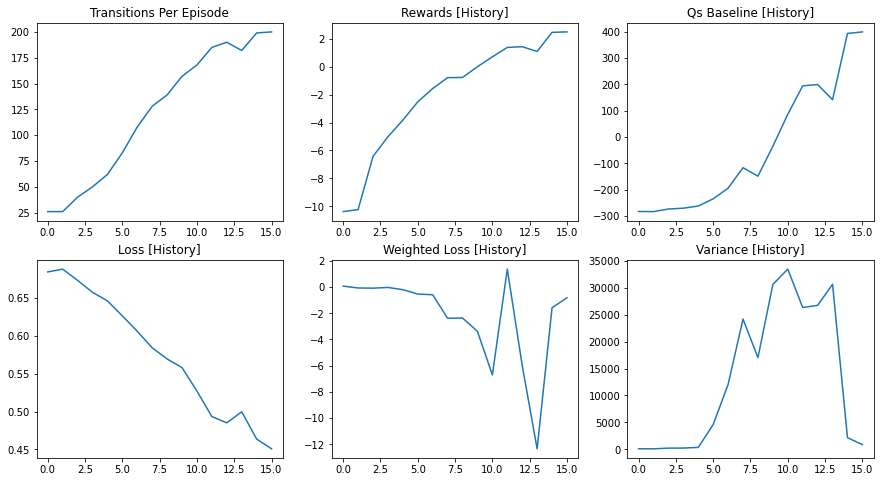

CPU times: user 7min 33s, sys: 2.29 s, total: 7min 35s
Wall time: 7min 34s


In [9]:
###### render = True
episodes = 1000


class Buffer(object):
    def __init__(self):

        self.reset_buffer()
        self.max_size = 10000000
    
    
    def reset_buffer(self):
        self.prev_obs = np.array([])
        self.obs = np.array([])
        self.actions = np.array([])
        self.rewards = np.array([])
        self.terminals = np.array([])
        self.q_values = np.array([])
    
    
    def update(self, eps_prev_obs, eps_obs, eps_actions, eps_rewards, eps_terminals, eps_q_values):
        
        self.prev_obs = np.concatenate([self.prev_obs, eps_prev_obs])[-self.max_size:]
        self.obs = np.concatenate([self.obs, eps_obs])[-self.max_size:]
        self.actions = np.concatenate([self.actions, eps_actions])[-self.max_size:]
        self.rewards = np.concatenate([self.rewards, eps_rewards])[-self.max_size:]
        self.terminals = np.concatenate([self.terminals, eps_terminals])[-self.max_size:]
        self.q_values = np.concatenate([self.q_values, eps_q_values])[-self.max_size:]
        
        self.indexes = np.random.permutation(range(len(self.obs)))
    

    
    def get_samples(self, batch, batch_size):
        inds = self.indexes[batch*batch_size:(batch+1)*batch_size]
        
        return  self.prev_obs[inds], self.obs[inds], self.actions[inds],\
                self.rewards[inds], self.terminals[inds], self.q_values[inds]
    
        
        
        
        
class Policy(object):
    def __init__(self, env, nn_dims, learning_rate=0.01):
        self.env = env
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        
        print('Action Space', self.action_space)
        print('Observation Space', self.observation_space, '\nHigh',
                                   self.observation_space.high, '\nLow', self.observation_space.low,
                                   end='\n\n')
        
        self.epoch = 0
        self.learning_rate = learning_rate
        self.nn_dims = nn_dims
        self.build_nn()
        

        

    def build_nn(self):
        
        self.loss_history = []
        self.weighted_loss_history = []
        self.reward_history = []
        self.baseline_history = []
        self.variance_history = []
        
        layers = [tf.keras.Input(shape=self.observation_space.shape)]
        
        for d in self.nn_dims:
            layers.extend([
                tf.keras.layers.Dense(d, activation='relu', kernel_initializer='glorot_normal'),
                tf.keras.layers.Dropout(0.1),
            ])
            
        layers.append(tf.keras.layers.Dense(self.action_space.n, activation='softmax'))
        
        self.model = tf.keras.models.Sequential(layers) 
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
                
            
        
    def get_action(self, ob):
        
        model_output = self.model(tf.Variable([ob]))
        probs = model_output[0].numpy() / sum(model_output[0].numpy())
        action = np.random.choice(np.arange(len(model_output[0])), p=probs)
        return action

        
    
    def train_policy(self, eps_prev_obs, eps_obs, eps_actions, eps_rewards, eps_terminals, eps_q_values):
        print('Total obs', len(eps_prev_obs))
        
        obs = tf.Variable(eps_prev_obs)
        actions = tf.Variable(tf.one_hot(eps_actions, 2))
        
        mean_qs = statistics.mean(eps_q_values)
        qs = tf.Variable(np.array(eps_q_values) - mean_qs, dtype=float)
        
        with tf.GradientTape() as tape:
            logits = self.model(obs, training=True)
            negative_likelihoods = tf.nn.softmax_cross_entropy_with_logits(labels = actions, logits=logits)
            weighted_negative_likelihoods = tf.multiply(negative_likelihoods, qs)
            loss = tf.reduce_mean(weighted_negative_likelihoods)
            
        
        grads = tape.gradient(loss, self.model.trainable_variables) 
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        self.loss_history.append(tf.reduce_mean(negative_likelihoods))
        self.weighted_loss_history.append(loss.numpy().mean())
        self.reward_history.append(sum(eps_rewards)/len(eps_rewards))
        self.baseline_history.append(mean_qs)
        self.variance_history.append(tfp.stats.variance(weighted_negative_likelihoods))
            
 
        
class Agent(object):
    
    def __init__(self, env, nn_dims):
        self.env = env
        self.policy = Policy(env, nn_dims)
        self.rewards =  0

    def take_action(self, ob):
        return self.policy.get_action(ob)

    def train(self, eps_prev_obs, eps_obs, eps_actions, eps_rewards, eps_terminals, eps_q_values):
        self.rewards = 0
        ret = self.policy.train_policy(eps_prev_obs, eps_obs, eps_actions, 
                                       eps_rewards, eps_terminals, eps_q_values)
        return ret


class Episode(object):
    def __init__(self, env, agent, render):
        
        self.env = env
        self.agent = agent
        self.render = render
        
        self.prev_obs = []
        self.obs = []
        self.actions = []
        self.rewards = []
        self.terminals = []

        
    def run(self):
        observation = self.env.reset()
        done = False
        t = 0
        while not done:
            if self.render == True: self.env.render()
            action = self.agent.take_action(observation)
            prev_ob = observation
            observation, reward, done, info = self.env.step(action)

            t = t + 1
            
            if done: reward = -300
            if t == self.env.spec.max_episode_steps: reward = 300
            
            self.rewards.append(reward)
            self.prev_obs.append(prev_ob)
            self.obs.append(observation)
            self.actions.append(action)
            self.terminals.append(done)
            
            if done: break
        
        q_values = []       
        gamma = 0.995
        
        for i in range(len(self.rewards)):
            cumul_sum = 0
            for j in range(len(self.rewards[i:])):
                cumul_sum = cumul_sum + self.rewards[i:][j] * math.pow(gamma, j)
            q_values.append(sum(self.rewards[i:]))
                
        return t, self.prev_obs, self.obs, self.actions, self.rewards, self.terminals, q_values


    
def run_episodes(env, agent, min_runs, min_transitions, render=False):
    
    transitions = 0
    runs = 0
    eps_prev_obs = []
    eps_obs = [] 
    eps_actions = [] 
    eps_rewards = [] 
    eps_terminals = []
    eps_q_values = []
    tot_rewards = []
    
    
    while (transitions < min_transitions) or (runs < min_runs):
        ep = Episode(env, agent, render)      
        ep_trans, prev_obs, obs, actions, rewards, terminals, q_values = ep.run()
        
        eps_prev_obs.extend(prev_obs)
        eps_obs.extend(obs) 
        eps_actions.extend(actions)
        eps_rewards.extend(rewards)
        eps_terminals.extend(terminals)
        eps_q_values.extend(q_values)
        tot_rewards.append(sum(rewards))
        
        transitions = transitions + ep_trans
        runs = runs + 1
    
    return runs, transitions, eps_prev_obs, eps_obs, eps_actions,\
           eps_rewards, eps_terminals, eps_q_values, tot_rewards


def run_epochs(env, agent, min_runs, min_transitions, epochs, mult = 4, div = 120, render=False):
    
    strikes = 0
    retries = 0
    max_strikes = 3
    tr_per_run = 9
    tr_per_run_arr = []
    
    buffer = Buffer()
    
    iterating = True
    
    while iterating:
        for i in range(epochs):
            clear_output(wait=True)

            if (i > 500) and tr_per_run == 9: 
                agent.policy.build_nn()
                agent.policy.loss_history = []
                tr_per_run_arr = []
                break

            if tr_per_run < div:
                req_transitions = (min_transitions * (tr_per_run + 1) / (mult*div))
                req_runs = (min_runs * (tr_per_run + 1) / (mult*div))
            else:
                req_transitions = min_transitions
                req_runs = min_runs

            runs, transitions, eps_prev_obs, eps_obs, eps_actions,\
            eps_rewards, eps_terminals, eps_q_values, tot_rewards =\
                                        run_episodes(env, agent, req_runs, req_transitions, render)

            agent.train(eps_prev_obs, eps_obs, eps_actions, eps_rewards, eps_terminals, eps_q_values)

            tr_per_run = int(transitions/runs)
            tr_per_run_arr.append(tr_per_run)

            agent.policy.epoch = i
            
            print("Retries", retries)
            print("Epoch:", i, tr_per_run, req_runs, req_transitions)
            print("Runs:", runs, ', Transitions:', transitions, ',', int(transitions/runs),'transitions per run')
            print("Total Rewards:", statistics.mean(tot_rewards))
            print('Strike', strikes)
            print('\n')

            if tr_per_run > 5:
                fig, axs = plt.subplots(2, 3, figsize=(15, 8))

                axs[0, 0].plot(tr_per_run_arr)
                axs[0, 0].set_title('Transitions Per Episode')

                axs[0, 1].plot(agent.policy.reward_history)
                axs[0, 1].set_title('Rewards [History]')

                axs[0, 2].plot(agent.policy.baseline_history)
                axs[0, 2].set_title('Qs Baseline [History]')

                axs[1, 0].plot(agent.policy.loss_history)
                axs[1, 0].set_title('Loss [History]')

                axs[1, 1].plot(agent.policy.weighted_loss_history)
                axs[1, 1].set_title('Weighted Loss [History]')

                axs[1, 2].plot(agent.policy.variance_history)
                axs[1, 2].set_title('Variance [History]')

                plt.show()



            if int(transitions/runs) >= env.spec.max_episode_steps:
                strikes = strikes + 1

            if transitions >= runs * (env.spec.max_episode_steps): 
                iterating = False
                break
                
            if strikes > max_strikes:
                break
                
        retries = retries + 1
             
            
            
min_transitions = 800
min_runs = 100
epochs = 5000
env = gym.make('CartPole-v0') 
agent = Agent(env, nn_dims = [64, 64, 64])

%time run_epochs(env, agent, min_runs, min_transitions, epochs, mult=2, div = 60, render=False)

env.close()

In [17]:
for i in range(100):
    ep = Episode(env, agent, render=True)      
    ep_trans, prev_obs, obs, actions, rewards, terminals, q_values = ep.run()
    print(i, len(q_values), sum(rewards), max(rewards))
    
    

0 13 -288.0 1.0
1 14 -287.0 1.0
2 15 -286.0 1.0
3 24 -277.0 1.0
4 14 -287.0 1.0
5 25 -276.0 1.0
6 12 -289.0 1.0
7 43 -258.0 1.0
8 14 -287.0 1.0
9 45 -256.0 1.0
10 16 -285.0 1.0
11 10 -291.0 1.0
12 12 -289.0 1.0
13 10 -291.0 1.0
14 34 -267.0 1.0
15 27 -274.0 1.0
16 12 -289.0 1.0
17 13 -288.0 1.0
18 21 -280.0 1.0
19 31 -270.0 1.0
20 12 -289.0 1.0
21 40 -261.0 1.0
22 12 -289.0 1.0
23 18 -283.0 1.0
24 20 -281.0 1.0
25 17 -284.0 1.0
26 12 -289.0 1.0
27 20 -281.0 1.0
28 41 -260.0 1.0
29 21 -280.0 1.0
30 19 -282.0 1.0
31 11 -290.0 1.0
32 18 -283.0 1.0
33 26 -275.0 1.0
34 24 -277.0 1.0
35 15 -286.0 1.0
36 11 -290.0 1.0
37 12 -289.0 1.0
38 15 -286.0 1.0
39 11 -290.0 1.0
40 15 -286.0 1.0
41 26 -275.0 1.0
42 14 -287.0 1.0
43 88 -213.0 1.0
44 9 -292.0 1.0
45 13 -288.0 1.0
46 14 -287.0 1.0
47 19 -282.0 1.0
48 21 -280.0 1.0
49 14 -287.0 1.0
50 10 -291.0 1.0
51 29 -272.0 1.0
52 46 -255.0 1.0
53 15 -286.0 1.0
54 17 -284.0 1.0
55 12 -289.0 1.0
56 16 -285.0 1.0
57 21 -280.0 1.0
58 14 -287.0 1.0
59 24 -2

In [ ]:
 agent.policy.model.save_weights('./model-64-64-64-vg')

In [59]:
 agent.policy.model.load_weights('./model-64-64-64-vg')